<a href="https://colab.research.google.com/github/JaySeeDub/Coding-Dojo/blob/main/Exercises/08_autoencoders_and_gans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Hands On #8

**Chapter 17 – Autoencoders and GANs**

File name convention: For group 42 and memebers Richard Stallman and Linus <br>
Torvalds it would be <br>
"08_group42_Stallman_Torvalds.pdf".

Submission via blackboard (UA).

Feel free to answer free text questions in text cells using markdown and <br>
possibly $\LaTeX{}$ if you want to.

**You don't have to understand every line of code here and it is not intended <br>
for you to try to understand every line of code.   <br>
Big blocks of code are usually meant to just be clicked through.**

# Setup

In [1]:
# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
from tensorflow import keras

import numpy as np
import os

np.random.seed(42)
torch.manual_seed(42)
torch.cuda.manual_seed_all

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [2]:

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

A couple utility functions to plot grayscale 28x28 image:

In [3]:
def plot_image(image):
    plt.imshow(np.moveaxis(image, 0, 2), cmap="binary")
    plt.axis("off")

# Simple linear Autoencoder (PCA)

Autoencoders are form of **unsupervised learning** algorithm that attempt to encode <br>
or **transform** an input into some sort of (typically **lower-dimensional**) space <br>
where it has different values and then decode the encoded data back to its <br>
**original state**. A consequence of this approach is that your model learns the <br>
**characteristic behavior** of your data set. Once trained, autoencoders can do <br>
everything from **detect anomalies** and outliers in unseen data to **adding or** even <br>
**removing noise** from new data.

Build 3D dataset:

In [12]:
np.random.seed(4)

def generate_3d_data(m, w1=0.1, w2=0.3, noise=0.1):
    """create some 3d data with noise"""
    angles = np.random.rand(m) * 3 * np.pi / 2 - 0.5
    data = np.empty((m, 3))
    data[:, 0] = np.cos(angles) + np.sin(angles)/2 + noise * np.random.randn(m) / 2
    data[:, 1] = np.sin(angles) * 0.7 + noise * np.random.randn(m) / 2
    data[:, 2] = data[:, 0] * w1 + data[:, 1] * w2 + noise * np.random.randn(m)
    return data

X_train = generate_3d_data(1000)
X_train = X_train - X_train.mean(axis=0, keepdims=0)

X_val = generate_3d_data(1000)
X_val = X_val - X_val.mean(axis=0, keepdims=0)

In [13]:
class AutoencoderDataset(Dataset):
    def __init__(self, X):
        self.X = torch.from_numpy(X.copy()).float()
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx]

train_data = AutoencoderDataset(X_train)

train_loader = DataLoader(train_data, batch_size=1, shuffle=True)

val_data = AutoencoderDataset(X_val)

val_loader = DataLoader(val_data, batch_size=1, shuffle=True)

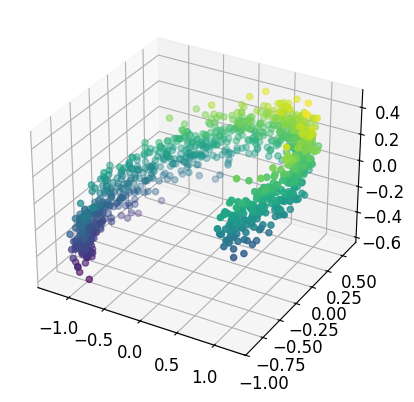

In [14]:
ax = plt.axes(projection="3d")
ax.scatter3D(X_train[:,0], X_train[:,1], X_train[:,2], c=X_train[:,2], cmap="viridis")

Let's try to "compress" the data using an autoencoder.

As a sidenote: Compression is tightly linked to intelligence and there are even arguments
that compression might be all there is to intelligence.   
If you are interested in this topic you can read about the [Hutter prize](http://prize.hutter1.net/hrules.htm).

Now let's build the Autoencoder...

In [22]:
np.random.seed(42)
torch.manual_seed(42)

# encoder: from 3 to 2 dimensions
encoder = nn.Sequential(nn.Linear(3, 2))
# decoder: from 2 to 3 dimensions
decoder = nn.Sequential(nn.Linear(2, 3))


In [23]:
print(encoder)

Sequential(
  (0): Linear(in_features=3, out_features=2, bias=True)
)


In [24]:
print(decoder)

Sequential(
  (0): Linear(in_features=2, out_features=3, bias=True)
)


In [25]:
def ae_train_and_validate(train_loader, val_loader, model, optimizer, criterion, num_epochs, metric=None, scheduler=None, device='cpu'):
    history = {
        'epoch': [],
        'train_loss': [],
        'train_metric': [],
        'val_loss': [],
        'val_metric': [],
        'learning_rate': []
    }  # Initialize a dictionary to store epoch-wise results

    model.to(device)  # Move the model to the specified device

    with torch.no_grad():
        proper_dtype = torch.int64
        X = next(iter(train_loader))
        X = X.to(device)
        try:
            loss = criterion(model(X), X)
        except:
            try:
                proper_dtype = torch.float32
                loss = criterion(model(X), X)
            except:
                print("No valid data-type could be found")

    for epoch in range(num_epochs):
        model.train()  # Set the model to training mode
        epoch_loss = 0.0  # Initialize the epoch loss and metric values
        epoch_metric = 0.0

        # Training loop
        for X in train_loader:
            X = X.to(device)
            optimizer.zero_grad()  # Clear existing gradients
            outputs = model(X)  # Make predictions
            loss = criterion(outputs, X)  # Compute the loss
            loss.backward()  # Compute gradients
            optimizer.step()  # Update model parameters

            epoch_loss += loss.item()

            if metric is not None:
                epoch_metric += metric(outputs, X)
            else:
                epoch_metric += 0.0

        # Average training loss and metric
        epoch_loss /= len(train_loader)
        epoch_metric /= len(train_loader)

        # Validation loop
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():  # Disable gradient calculation
            val_loss = 0.0
            val_metric = 0.0
            for X_val in val_loader:
                X_val = X_val.to(device)
                outputs_val = model(X_val)  # Make predictions
                val_loss += criterion(outputs_val, X_val).item()  # Compute loss
                if metric is not None:
                    val_metric += metric(outputs_val, X_val)
                else:
                    val_metric += 0.0

            val_loss /= len(val_loader)
            val_metric /= len(val_loader)

        # Append epoch results to history
        history['epoch'].append(epoch)
        history['train_loss'].append(epoch_loss)
        history['train_metric'].append(epoch_metric)
        history['val_loss'].append(val_loss)
        history['val_metric'].append(val_metric)
        history['learning_rate'].append(optimizer.param_groups[0]['lr'])

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, '
              f'Train Metric: {epoch_metric:.4f}, Val Loss: {val_loss:.4f}, '
              f'Val Metric: {val_metric:.4f}')

        if scheduler is not None:
            scheduler.step()

    return history, model

In [26]:
def ae_test_model(model, data_loader, criterion, metric=None, device='cpu'):
    model.to(device)  # Move the model to the specified device

    model.eval()  # Set the model to evaluation mode

    total_loss = 0.0  # Initialize the total loss and metric values
    total_metric = 0.0

    with torch.no_grad():
        proper_dtype = torch.int64
        X = next(iter(data_loader))
        X = X.to(device)
        try:
            loss = criterion(model(X), X)
        except:
            try:
                proper_dtype = torch.float32
                loss = criterion(model(X), X)
            except:
                print("No valid data-type could be found")


    with torch.no_grad():  # Disable gradient tracking
        for batch in data_loader:
            X, y = batch
            X = X.to(device)

            # Pass the data to the model and make predictions
            outputs = model(X)

            # Compute the loss
            loss = criterion(outputs, X)

            # Add the loss and metric for the batch to the total values
            total_loss += loss.item()

            if metric is not None:
                total_metric += metric(outputs, X)
            else:
                total_metric += 0.0

    # Average loss and metric for the entire dataset
    avg_loss = total_loss / len(data_loader)
    avg_metric = total_metric / len(data_loader)

    print(f'Test Loss: {avg_loss:.4f}, Test Metric: {avg_metric:.4f}')

    return avg_loss, avg_metric

## Task 1:
If you don't understand autoencoders, we strongly recommend reading the parts <br>
in the book (Chapter 17) first.

a) Build an autoencoder model with the two subcomponents: the encoder and the <br>
decoder. All you have to do is to "stack" the encoder and decoder, `encoder,` <br> `decoder` in a `nn.Sequential`.  <br>
b) Train the model using `ae_train_and_validate()` with `MSELoss` <br>
SGD optimizer with lr=0.01, train_loader (20 epochs). Be sure to just pass
<br>
train_loader twice as there's no valid_loader for this section.<br>
c) Encode the dataset using only the trained encoder. The `encoder` will be <br>
mutated by the autoencoder training, so you can just use it to do this step <br>
because it is already trained. Call the output `codings` for the plotting code <br>
below.<br>
d) Look at the plot of the encodings and explain the purpose of this <br> encoder. <br>
e) Decode the encodings again and plot them in 3D using the same code as above <br>
when we plot `X_train`.


↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓ your code goes below

In [27]:
autoencoder = nn.Sequential(
    encoder,
    decoder,
)
optimizer = torch.optim.NAdam(autoencoder.parameters(), lr=.01)
criterion = nn.MSELoss()

Epoch [1/20], Train Loss: 0.0233, Train Metric: 0.0000, Val Loss: 0.0034, Val Metric: 0.0000
Epoch [2/20], Train Loss: 0.0034, Train Metric: 0.0000, Val Loss: 0.0033, Val Metric: 0.0000
Epoch [3/20], Train Loss: 0.0034, Train Metric: 0.0000, Val Loss: 0.0035, Val Metric: 0.0000
Epoch [4/20], Train Loss: 0.0035, Train Metric: 0.0000, Val Loss: 0.0034, Val Metric: 0.0000
Epoch [5/20], Train Loss: 0.0035, Train Metric: 0.0000, Val Loss: 0.0037, Val Metric: 0.0000
Epoch [6/20], Train Loss: 0.0035, Train Metric: 0.0000, Val Loss: 0.0033, Val Metric: 0.0000
Epoch [7/20], Train Loss: 0.0035, Train Metric: 0.0000, Val Loss: 0.0039, Val Metric: 0.0000
Epoch [8/20], Train Loss: 0.0035, Train Metric: 0.0000, Val Loss: 0.0031, Val Metric: 0.0000
Epoch [9/20], Train Loss: 0.0035, Train Metric: 0.0000, Val Loss: 0.0035, Val Metric: 0.0000
Epoch [10/20], Train Loss: 0.0035, Train Metric: 0.0000, Val Loss: 0.0039, Val Metric: 0.0000
Epoch [11/20], Train Loss: 0.0035, Train Metric: 0.0000, Val Loss: 0.

In [ ]:
history, model = ae_train_and_validate(train_loader, val_loader, autoencoder, optimizer, criterion, 20)

In [28]:
codings = encoder(torch.from_numpy(np.asarray(X_train, np.float32))).to('cpu').detach().numpy()

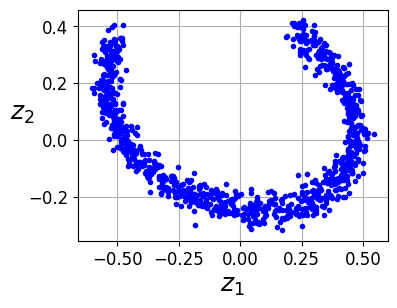

In [33]:
fig = plt.figure(figsize=(4,3))
plt.plot(codings[:,0], codings[:, 1], "b.")
plt.xlabel("$z_1$", fontsize=18)
plt.ylabel("$z_2$", fontsize=18, rotation=0)
plt.grid(True)
plt.show()

In [34]:
decoded_data = decoder(torch.from_numpy(codings).float()).to('cpu').detach().numpy()

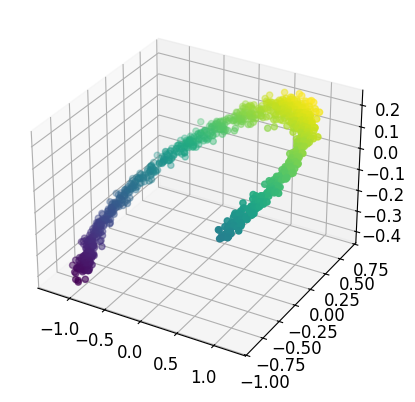

In [35]:
ax = plt.axes(projection="3d")
ax.scatter3D(decoded_data[:,0], decoded_data[:,1], decoded_data[:,2], c=decoded_data[:,2], cmap="viridis")

Task 1d) answer:

The encoder reduces the dimensionality of the dataset, in htis case from 3D to 2D.

Task 1e) answer:

The decoder then takes that reduced dimesnional data as input and outputs something of higher dimension, in this case 2D to 3D.

↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑ your code goes above

# Autoencoder for MNIST
Let's use the MNIST dataset.

In [36]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [37]:
class AutoencoderDataset(Dataset):
    def __init__(self, X):
        self.X = torch.from_numpy(X.copy()).float()
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx]

train_data = AutoencoderDataset(X_train)
valid_data = AutoencoderDataset(X_valid)
test_data = AutoencoderDataset(X_test)

batch_size = 64

train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False, drop_last=True)
test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, drop_last=True)

Let's build a stacked Autoencoder with 3 hidden layers and 1 output layer (i.e., 2 stacked Autoencoders).

In [38]:
encoder2 = nn.Sequential(
    nn.Flatten(),
    nn.Linear(784, 100),
    nn.SELU(),
    nn.Linear(100, 30),
    nn.SELU(),
)

## Task 2:
a) Above the code for the encoder is given. Build the corresponding decoder <br>
(`decoder2`). The last two layers of the decoder will have to be <br>
`nn.Sigmoid()` and `nn.Unflatten(1,(28, 28))`. Just like in task 1, build
<br>
`autoencoder2` from `encoder2` and `decoder2`.<br>
b) Train the model using `ae_train_and_validate()` with binary cross <br>
entropy, SGD optimizer with lr=0.1, train_loader (30 epochs) and <br> valid_loader.<br>
c) Using the function `show_reconstructions` below, look at the reconstructions <br>
and comment on them.

In [39]:
def show_reconstructions(model, dataloader=valid_loader, n_images=5, extra_layer=None):
    model.eval()

    for images in dataloader:
        break

    if images.shape[1] != 1:
        images = images.unsqueeze(1)

    images = images.to(next(model.parameters()).device)
    if extra_layer is not None:
        extra_layer.to(next(model.parameters()).device)
        images = extra_layer(images)

    with torch.no_grad():
        reconstructions = model(images[:n_images])

    if isinstance(reconstructions, tuple):
        reconstructions = reconstructions[0]  # Assume the first element is what we need
    reconstructions = reconstructions.to('cpu').detach().numpy()

    if reconstructions.shape[1] != 1:
        reconstructions = reconstructions[:,np.newaxis,...]

    plt.figure(figsize=(10, 4))
    for image_index in range(n_images):
        plt.subplot(2, n_images, 1 + image_index)
        plot_image(images.to('cpu').detach().numpy()[image_index])
        plt.subplot(2, n_images, 1 + n_images + image_index)
        plot_image(reconstructions[image_index])
    plt.show()

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓ your code goes below

In [42]:
decoder2 = nn.Sequential(
    nn.Linear(30, 100),
    nn.SELU(),
    nn.Linear(100, 784),
    nn.Sigmoid(),
    nn.Unflatten(1,(28, 28)))

autoencoder2 = nn.Sequential(encoder2, decoder2)
optimizer = torch.optim.SGD(autoencoder2.parameters(), lr=0.1)
criterion = nn.BCELoss()
history, autoencoder2 = ae_train_and_validate(train_loader, valid_loader, autoencoder2, optimizer, criterion, 30)

Epoch [1/30], Train Loss: 0.5623, Train Metric: 0.0000, Val Loss: 0.4935, Val Metric: 0.0000
Epoch [2/30], Train Loss: 0.4682, Train Metric: 0.0000, Val Loss: 0.4425, Val Metric: 0.0000
Epoch [3/30], Train Loss: 0.4119, Train Metric: 0.0000, Val Loss: 0.3897, Val Metric: 0.0000
Epoch [4/30], Train Loss: 0.3766, Train Metric: 0.0000, Val Loss: 0.3730, Val Metric: 0.0000
Epoch [5/30], Train Loss: 0.3666, Train Metric: 0.0000, Val Loss: 0.3661, Val Metric: 0.0000
Epoch [6/30], Train Loss: 0.3604, Train Metric: 0.0000, Val Loss: 0.3605, Val Metric: 0.0000
Epoch [7/30], Train Loss: 0.3550, Train Metric: 0.0000, Val Loss: 0.3552, Val Metric: 0.0000
Epoch [8/30], Train Loss: 0.3501, Train Metric: 0.0000, Val Loss: 0.3507, Val Metric: 0.0000
Epoch [9/30], Train Loss: 0.3459, Train Metric: 0.0000, Val Loss: 0.3468, Val Metric: 0.0000
Epoch [10/30], Train Loss: 0.3424, Train Metric: 0.0000, Val Loss: 0.3435, Val Metric: 0.0000
Epoch [11/30], Train Loss: 0.3391, Train Metric: 0.0000, Val Loss: 0.

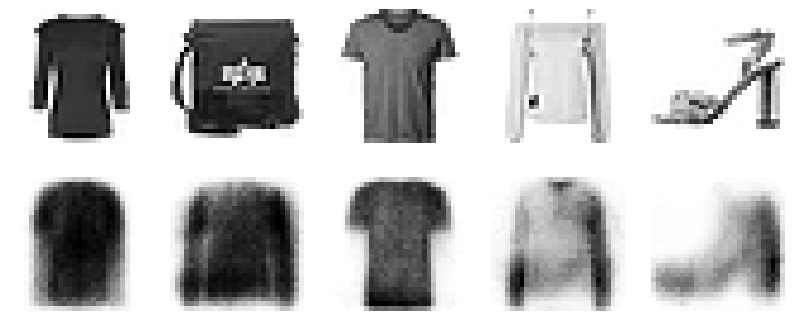

In [46]:
show_reconstructions(autoencoder2)

Task 2c) answer:

All of the images lose clarity, and one of them has been misinterpreted as a different class. But the images are all recognizable as the class they're meant to be.

↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑ your code goes above

### "Looking" at the encoding
Here we wil in some sense "look" at the encoding. <br>
We will use TSNE to transform the encoding to 2D and then plot in a 2D plane.<br>

No questions to anwer here, just look at the plots.

In [47]:
!pip install bhtsne

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.2/86.2 kB 2.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for bhtsne: filename=bhtsne-0.1.9-cp311-cp311-linux_x86_64.whl size=280151 sha256=e86a162c874960dd539ea30635f8e83c1d950fc5999a9851d58a9157c76ef55a
  Stored in directory: /root/.cache/pip/wheels/c7/e0/05/ef25429ca93e3ccaddddb1ed036fb692b6b99f078b83937842
Successfully built bhtsne


In [ ]:
#Textbook uses from sklearn.manifold import TSNE but that has known bugs w/ colab on mac
from bhtsne import tsne

encoder2 = encoder2.to(device)
X_valid_compressed = [encoder2(v.to(device)).to('cpu').detach().numpy() for v in valid_loader]
X_valid_compressed = np.concatenate(X_valid_compressed, dtype=np.float64)
X_valid_2D = tsne(X_valid_compressed)
X_valid_2D = (X_valid_2D - X_valid_2D.min()) / (X_valid_2D.max() - X_valid_2D.min())

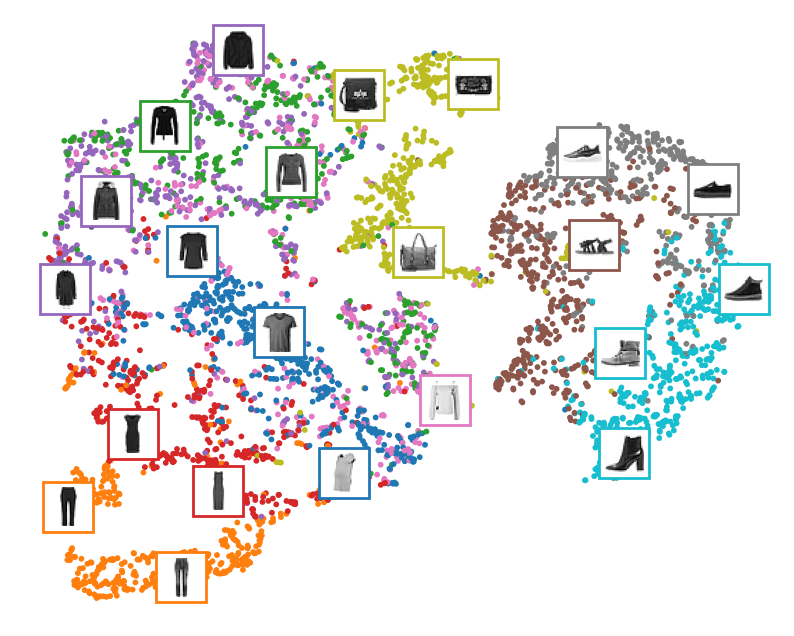

In [49]:
# adapted from https://scikit-learn.org/stable/auto_examples/manifold/plot_lle_digits.html
plt.figure(figsize=(10, 8))
cmap = plt.cm.tab10
plt.scatter(X_valid_2D[:, 0], X_valid_2D[:, 1], c=y_valid[:-8], s=10, cmap=cmap)
image_positions = np.array([[1., 1.]])
for index, position in enumerate(X_valid_2D):
    dist = np.sum((position - image_positions) ** 2, axis=1)
    if np.min(dist) > 0.02: # if far enough from other images
        image_positions = np.r_[image_positions, [position]]
        imagebox = mpl.offsetbox.AnnotationBbox(
            mpl.offsetbox.OffsetImage(X_valid[index], cmap="binary"),
            position, bboxprops={"edgecolor": cmap(y_valid[index]), "lw": 2})
        plt.gca().add_artist(imagebox)
plt.axis("off")
plt.show()

##GPU Time:
**If you haven't enabled GPU in your colab notebook, now is the time to do so.** <br>
Only one group member should be working with GPU at a time as you will each <br>
have a limit on how often and for how long colab will allow you to use gpu.

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Using Convolutional Layers Instead of Dense Layers

Let's build a stacked Autoencoder with 3 hidden layers and 1 output layer (i.e., 2 stacked Autoencoders).

In [ ]:
torch.manual_seed(42)
np.random.seed(42)

conv_encoder = nn.Sequential(
    nn.Conv2d(1, 16, kernel_size=3, padding=1),
    nn.SELU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(16, 32, kernel_size=3, padding=1),
    nn.SELU(),
    nn.MaxPool2d(kernel_size=2),
    nn.Conv2d(32, 64, kernel_size=3, padding=1),
    nn.SELU(),
    nn.MaxPool2d(kernel_size=2)
)

conv_decoder = nn.Sequential(
    # Start reversing the process, assuming the final encoder output is 3x3x64 for a 28x28 input
    nn.ConvTranspose2d(64, 32, kernel_size=3, stride=2, padding=0),  # Upscale to 7x7
    nn.SELU(),
    # Upscale from 7x7 to 14x14
    nn.ConvTranspose2d(32, 16, kernel_size=3, stride=2, padding=1, output_padding=1),
    nn.SELU(),
    # Final upscale from 14x14 to 28x28
    nn.ConvTranspose2d(16, 1, kernel_size=3, stride=2, padding=1, output_padding=1),
    nn.Sigmoid()
)


### Reloading Dataset with Proper Shape for Convolution

Above is a visual representation of the encoder. Alas visualkeras does not <br>
support `ConvTranspose2d` so we cannot plot the decoder here.

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255
X_test = X_test.astype(np.float32) / 255
X_train, X_valid = X_train_full[:-5000], X_train_full[-5000:]
y_train, y_valid = y_train_full[:-5000], y_train_full[-5000:]


#Notice that pytorch convolutional layers expect the 1-axis to be the channels
#dimension whereas generally linear layers will act on the last axis.

X_train = X_train[:, np.newaxis, ...]
X_valid = X_valid[:, np.newaxis, ...]
X_test = X_test[:, np.newaxis, ...]

In [ ]:
class AutoencoderDataset(Dataset):
    def __init__(self, X):
        self.X = torch.from_numpy(X.copy()).float()
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx]

train_data = AutoencoderDataset(X_train)
valid_data = AutoencoderDataset(X_valid)
test_data = AutoencoderDataset(X_test)

batch_size = 64

conv_train_loader = DataLoader(train_data, batch_size=batch_size, shuffle=True, drop_last=True)
conv_valid_loader = DataLoader(valid_data, batch_size=batch_size, shuffle=False, drop_last=True)
conv_test_loader = DataLoader(test_data, batch_size=batch_size, shuffle=False, drop_last=True)

### Task 3:
a) Build an autoencoder model with the two subcomponents: the convolutional <br>
encoder and the convolutional decoder.<br>
b) Train the model using `ae_train_and_validate()` with binary cross <br>
entropy, SGD optimizer with lr=0.1, conv_train_loader (30 epochs) and <br> conv_valid_loader.<br>
c) Is the CNN autoencoder better than dense layer's autoencoders? Why?<br>
d) What is the shape/size of the input and what is the shape/size of the<br>
encoding? Compare to the autoencoder above. (This is similar to task 2c)

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓ your code goes below

In [ ]:
#conv_ae = nn.Sequential(...
#optimizer = ...
#criterion =

In [ ]:
#history, conv_ae = ae_train_and_validate(

↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑ your code goes above

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓ your answer goes below

Task 3c) answer:

Task 3d) answer:

↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑ your answer goes above

In [ ]:
show_reconstructions(conv_ae, conv_test_loader)
plt.show()

# Denoising Autoencoder

Below we have a similar autoencoder as before, but with an extra <br> `GaussianNoise` layer directly after the input.

In [ ]:
#Source: whywww and YannDubs1 from pytorch forums
#https://discuss.pytorch.org/t/writing-a-simple-gaussian-noise-layer-in-pytorch/4694/8
class GaussianNoise(nn.Module):
    """Gaussian noise regularizer.

    Args:
        sigma (float, optional): relative standard deviation used to generate the
            noise. Relative means that it will be multiplied by the magnitude of
            the value your are adding the noise to. This means that sigma can be
            the same regardless of the scale of the vector.
        is_relative_detach (bool, optional): whether to detach the variable before
            computing the scale of the noise. If `False` then the scale of the noise
            won't be seen as a constant but something to optimize: this will bias the
            network to generate vectors with smaller values.
    """
    def __init__(self, sigma=0.1, is_relative_detach=True):
        super().__init__()
        self.sigma = sigma
        self.is_relative_detach = is_relative_detach
        self.register_buffer('noise', torch.tensor(0))

    def forward(self, x):
        if self.training and self.sigma != 0:
            scale = self.sigma * x.detach() if self.is_relative_detach else self.sigma * x
            sampled_noise = self.noise.expand(*x.size()).float().normal_() * scale
            x = x + sampled_noise
        return x

In [ ]:
torch.manual_seed(42)
np.random.seed(42)

denoising_encoder = nn.Sequential(
    nn.Flatten(),
    GaussianNoise(0.2),
    nn.Linear(784, 100),
    nn.SELU(),
    nn.Linear(100, 30),
    nn.SELU()
)

denoising_decoder = nn.Sequential(
    nn.Linear(30, 100),
    nn.SELU(),
    nn.Linear(100, 784),
    nn.Sigmoid(),
    nn.Unflatten(1, (1, 28, 28))
)

### Task 4:
a) Build an autoencoder model with the two subcomponents: the encoder and the <br>
decoder.<br>
b) Train the model using `ae_train_and_validate()` with binary cross <br>
entropy, SGD optimizer with lr=1.0, train_loader (30 epochs) and <br> valid_loader.<br>
c) Explain why adding Gaussian noise to the input would help the autoencoder to <br>
learn.   

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓ your code goes below

In [ ]:
#denoising_ae = nn.Sequential(...
#optimizer = ...
#criterion = ...
#history, denoising_ae = ...

↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑ your code goes above

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓ your answer goes below

Task 4c) answer:

↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑ your answer goes above

In [ ]:
torch.manual_seed(42)
np.random.seed(42)

noise = GaussianNoise(0.2)
show_reconstructions(denoising_ae, extra_layer=noise)
plt.show()

In [ ]:
show_reconstructions(denoising_ae)   # denoising autoencoder applied to "sharp" images
plt.show()

In [ ]:
show_reconstructions(autoencoder2)   # original autoencoder without Gaussian noise
plt.show()

# Variational Autoencoder

### Task 5:
Below you see the implementation of a variational autoencoder.   

a) Explain how a variational autoencoder works. What are the differences to a<br>
normal autoencoder? <br>
b) Explain how you would "generate" new data with a variational autoencoder.

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓ your answer goes below

Task 5a) answer:

Task 5b) answer:

↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑ your answer goes above

In [ ]:
class Sampling(nn.Module):
    def forward(self, inputs):
        mean, log_var = inputs
        std = torch.exp(0.5 * log_var)
        eps = torch.randn_like(std)
        return eps.mul(std).add_(mean)

In [ ]:
torch.manual_seed(42)
np.random.seed(42)

class VariationalEncoder(nn.Module):
    def __init__(self, codings_size):
        super(VariationalEncoder, self).__init__()
        self.linear1 = nn.Linear(28*28, 150)
        self.linear2 = nn.Linear(150, 100)
        self.codings_mean = nn.Linear(100, codings_size)
        self.codings_log_var = nn.Linear(100, codings_size)
        self.sampling = Sampling()

    def forward(self, x):
        x = F.selu(self.linear1(x.view(-1, 28*28)))
        x = F.selu(self.linear2(x))
        codings_mean = self.codings_mean(x)
        codings_log_var = self.codings_log_var(x)
        codings = self.sampling([codings_mean, codings_log_var])
        return codings_mean, codings_log_var, codings

class VariationalDecoder(nn.Module):
    def __init__(self, codings_size):
        super(VariationalDecoder, self).__init__()
        self.linear1 = nn.Linear(codings_size, 100)
        self.linear2 = nn.Linear(100, 150)
        self.linear3 = nn.Linear(150, 28*28)

    def forward(self, x):
        x = F.selu(self.linear1(x))
        x = F.selu(self.linear2(x))
        x = torch.sigmoid(self.linear3(x))
        return x.view(-1, 28, 28)

class VariationalAutoencoder(nn.Module):
    def __init__(self, codings_size):
        super(VariationalAutoencoder, self).__init__()
        self.encoder = VariationalEncoder(codings_size)
        self.decoder = VariationalDecoder(codings_size)

    def forward(self, x):
        codings_mean, codings_log_var, codings = self.encoder(x)
        reconstructions = self.decoder(codings)
        return reconstructions, codings_mean, codings_log_var

In [ ]:
def vae_loss(recon_x, x, mu, logvar):
    # Binary Cross Entropy
    BCE = torch.nn.functional.binary_cross_entropy(recon_x.view(-1, 784), x.view(-1, 784), reduction='mean')
    # KL Divergence
    KLD = -0.5 * torch.mean(1 + logvar - mu.pow(2) - logvar.exp()) / 784
    return BCE + KLD

In [ ]:
def vae_train_and_validate(train_loader, val_loader, model, optimizer, num_epochs, metric=None, scheduler=None, device='cpu'):
    history = {
        'epoch': [],
        'train_loss': [],
        'train_metric': [],
        'val_loss': [],
        'val_metric': [],
        'learning_rate': []
    }

    model.to(device)

    for epoch in range(num_epochs):
        model.train()
        epoch_loss = 0.0
        epoch_metric = 0.0

        for X in train_loader:
            X = X.to(device)
            optimizer.zero_grad()
            recon_batch, mu, logvar = model(X)
            loss = vae_loss(recon_batch, X, mu, logvar)
            loss.backward()
            optimizer.step()

            epoch_loss += loss.item()

        epoch_loss /= len(train_loader.dataset)

        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for X_val in val_loader:
                X_val = X_val.to(device)
                recon_batch, mu, logvar = model(X_val)
                val_loss += vae_loss(recon_batch, X_val, mu, logvar).item()

        val_loss /= len(val_loader.dataset)

        history['epoch'].append(epoch)
        history['train_loss'].append(epoch_loss)
        history['val_loss'].append(val_loss)
        history['learning_rate'].append(optimizer.param_groups[0]['lr'])

        print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {epoch_loss:.4f}, Val Loss: {val_loss:.4f}')

        if scheduler is not None:
            scheduler.step()

    return history, model

In [ ]:
codings_size = 10
variational_ae = VariationalAutoencoder(codings_size)
optimizer = torch.optim.SGD(variational_ae.parameters(), lr=1)
history, variational_ae = vae_train_and_validate(train_loader, valid_loader, variational_ae, optimizer, num_epochs=30, device=device)

In [ ]:
show_reconstructions(variational_ae)
plt.show()

## Generate Fashion Images
Now that we have a variational autoencoder, we can use it to generate fashion <br>
images.

In [ ]:
def plot_multiple_images(images, n_cols=None):
    n_cols = n_cols or len(images)
    n_rows = (len(images) - 1) // n_cols + 1
    if images.shape[-1] == 1:
        images = np.squeeze(images, axis=-1)
    plt.figure(figsize=(n_cols, n_rows))
    for index, image in enumerate(images):
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(image, cmap="binary")
        plt.axis("off")

Let's generate a few random codings, decode them and plot the resulting images:

### Task 6:
a) Take the encoding of the first image `X_train[0:1]` and add multiples (-10 <br>
to 10) of `np.array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0])`. Decode and plot using <br>
`plot_multiple_images()`. <br>
**Hint:** The output of `variational_encoder` is  <br>`[codings_mean, codings_log_var, codings]` and you only need the codings, not <br>
the mean and var. <br>
b) Generate few (e.g. 12) random codings using for example [torch.randn](https://pytorch.org/docs/stable/generated/torch.randn.html). <br>
Decode them and plot the resulting images using `plot_multiple_images(images, 4)`:

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓ your code goes below

In [ ]:
# initial_codings = variational_ae.encoder(...

# coding_root = torch.tensor(np.array([0, 0, 1, 0, 0, 0, 0, 0, 0, 0])).unsqueeze(0).to(device).to(torch.float32)
# codings = []
# for num  in range(-10, 11):
#     codings.append(initial_codings + coding_root * num)

# codings = torch.stack(codings)
# images = variational_ae.decoder(...
# plot_multiple_images(images, 4)

# random_codings = ...

↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑ your code goes above

Now let's perform semantic interpolation between these images:

# Generative Adversarial Networks

### Task 7:
Look at the GAN implementation below.   
a) Explain what a Generative Adversarial Network does.   
b) Run the code below. During every epoch it plots a few images. Comment on the <br>
"progress" from epoch 1 to 50. <br>
The training takes a very long time, you can also simply go to [this link](https://github.com/ageron/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb) <br>
and look at the output under the section "Generative Adversarial Networks".

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓ your answer goes below

Task 7 a) answer:

Task 7b) answer:

↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑ your answer goes above

In [ ]:
np.random.seed(42)
torch.manual_seed(42)

codings_size = 30

generator = nn.Sequential(
    nn.Linear(codings_size, 100),
    nn.SELU(),
    nn.Linear(100, 150),
    nn.Linear(150, 28 * 28),
    nn.Unflatten(1, (1, 28, 28)),
    nn.Sigmoid()
)

discriminator = nn.Sequential(
    nn.Flatten(),
    nn.Linear(28*28, 150),
    nn.SELU(),
    nn.Linear(150, 100),
    nn.SELU(),
    nn.Linear(100, 1),
    nn.Sigmoid()
)


In [ ]:
gan = nn.Sequential(generator, discriminator)

In [ ]:
def train_gan(gan, dataset, batch_size, codings_size, n_epochs=50):
    generator, discriminator = gan
    gan.to(device)
    generator.to(device)
    discriminator.to(device)
    optimizer_gen = torch.optim.Adam(generator.parameters())
    optimizer_disc = torch.optim.Adam(discriminator.parameters())
    loss_fn = nn.BCELoss()

    for epoch in range(n_epochs):
        print("Epoch {}/{}".format(epoch + 1, n_epochs))
        for X_batch in dataset:  # Assuming dataset yields (images, labels)
            X_batch = X_batch.to(device)
            # Phase 1 - training the discriminator
            noise = torch.randn(batch_size, codings_size, device=device)
            generated_images = generator(noise)

            X_fake_and_real = torch.cat([generated_images.squeeze(1), X_batch], dim=0)
            y1 = torch.tensor([[0.]] * batch_size + [[1.]] * batch_size, device=device)

            discriminator.zero_grad()
            predictions = discriminator(X_fake_and_real)
            loss_d = loss_fn(predictions, y1)
            loss_d.backward()
            optimizer_disc.step()

            # Phase 2 - training the generator
            noise = torch.randn(batch_size, codings_size, device=device)
            y2 = torch.tensor([[1.]] * batch_size, device=device)

            generator.zero_grad()
            gen_images = generator(noise)
            gen_pred = discriminator(gen_images)
            loss_g = loss_fn(gen_pred, y2)
            loss_g.backward()
            optimizer_gen.step()

        plot_multiple_images(generated_images.detach().cpu().numpy().squeeze(1), 8)
        plt.show()


In [ ]:
train_gan(gan, train_loader, batch_size, codings_size, n_epochs=50)

In [ ]:
torch.manual_seed(42)
np.random.seed(42)

noise = torch.randn([batch_size, codings_size])
generated_images = generator(noise.to(device))
plot_multiple_images(generated_images.to('cpu').detach().numpy().squeeze(1), 8)

# Deep Convolutional GAN
This is the convolutional variant of the GAN. Again, you can simply look at <br>
the output from the [link](https://github.com/ageron/handson-ml2/blob/master/17_autoencoders_and_gans.ipynb). This model is large enough that it's not reasonable to <br>
train on colab so just look at the outputs and compare.

The section to look at in that link is also called **Deep Convolutional GAN**.

### Task 8:
a) Comment on the training progress of the Deep Convolutional GAN.   
b) Compare the results from the Deep Convolutional GAN with the results from <br>
task 7.

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓ your answer goes below

Task 8 a) answer:

Task 8b) answer:

↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑ your answer goes above

## Task 9 (Bonus): Model performance analysis

Analyze the performance of at least 3 models used in this exercise using at <br>
least two different metrics on the test data sets or newly generated data. <br>
Examples of metrics might be mean-squared error, mean-absolute error, etc. <br>

Further, provide a brief text description (less than 500 words) explaining the <br>
metric used and results.

↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓↓ your code goes below

Task 9) answer:

↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑↑ your code goes above this